# ML workshop
01/06/2020

## Bootstrap
Before we get started, ensure you have your machine setup. Here I am using Python 3 with `pip` (not conda):

```sh
python3 -m venv ml-env
. ml-env/bin/activate  # Windows: > ml-env\Scripts\activate
pip install -U pip
pip install -U setuptools wheel
pip install jupyter matplotlib tensorflow tensorflow_datasets jax jaxlib torch torchvision
jupyter notebook  # Opens an interactive web interface; then File⇒New Notebook.
# Feel free to run `ipython`—or `python`—instead, and work just on the CLI.
```

## What is machine-learning and artificial-intelligence?

## Why should I care?

## How do I ML?

There are some popular offerrings, of which I'll go through 3 today:
- TensorFlow (Google)
- JAX (Google)
- PyTorch (Facebook)

# MNIST
Very popular dataset in the machine-learning sphere, with the goal of figuring out from an image which arabic numeral it is.

![https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

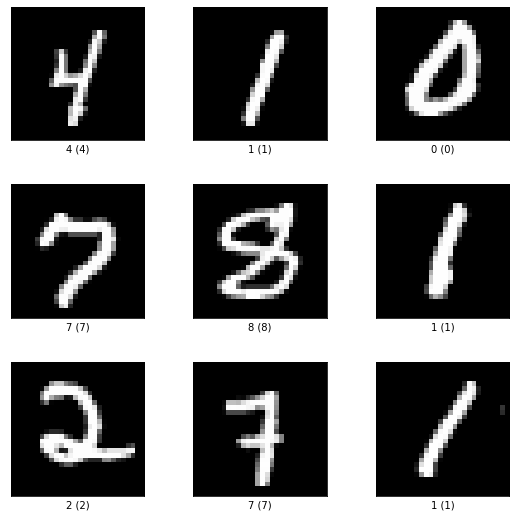

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [1]:
# Let's load in the dataset. This will be used for JAX and TensorFlow examples.
# (Although `as_numpy` would work fine with PyTorch, we want to use their recommended setup.)

from tempfile import gettempdir
from os import path
import tensorflow_datasets as tfds

data_dir = path.join(gettempdir(), 'tfds')

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, mnist_info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
tfds.show_examples(*tfds.load('mnist', split='train', with_info=True, data_dir=mnist_info.data_dir))
mnist_info

In [2]:
def globals_helper(k):
    globals_helper.i += 1

    return k if isinstance(k, (type(None), dict, float, int,
                               list, set, str)) \
        else None


globals_helper.i = 0
globals_before = frozenset(filter(None, map(globals_helper, globals())))
globals_i_before = globals_helper.i
globals_helper.i = 0
# globals_i_before, globals_before

# JAX
![JAX](https://raw.githubusercontent.com/google/jax/master/images/jax_logo_250px.png)
Think of it as numpy but for GPUs and TPUs. It is very focussed on composability.
> It can differentiate through loops, branches, recursion, and closures, and it can take derivatives of derivatives of derivatives. It supports reverse-mode differentiation (a.k.a. backpropagation) via grad as well as forward-mode differentiation, and the two can be composed arbitrarily to any order.

In [3]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp

### Hyperparameters
Let's get a few bookkeeping items out of the way.

In [4]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
param_scale = 0.1
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

/Users/samuel/repos/.venvs_py3/ml-env/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Auto-batching predictions

Let us first define our prediction function. Note that we're defining this for a _single_ image example. We then use JAX's `vmap` function to automatically handle mini-batches, with no performance penalty.

In [5]:
def relu(x):
    return np.maximum(0, x)


def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)


batched_predict = vmap(predict, in_axes=(None, 0))

### Utility and loss functions

In [6]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def accuracy(params, images, targets):
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(batched_predict(params, images), axis=1)
    return np.mean(predicted_class == target_class)


def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -np.mean(preds * targets)


@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, grads)]

### Data Loading with `tensorflow/datasets`

JAX is laser-focused on program transformations and accelerator-backed NumPy, so we don't include data loading or munging in the JAX library. There are already a lot of great data loaders out there, so let's just use them instead of reinventing anything. We'll use the `tensorflow/datasets` data loader.

In [7]:
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = mnist_info.features['label'].num_classes
h, w, c = mnist_info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = np.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = np.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [8]:
print('Train:'.ljust(6), train_images.shape, train_labels.shape,
      '\nTest:'.ljust(7), test_images.shape, test_labels.shape)
len('9253333210945129')

Train: (60000, 784) (60000, 10) 
Test:  (10000, 784) (10000, 10)


16

### Training Loop

In [9]:
import time


def get_train_batches():
    # as_supervised=True gives us the (image, label) as a tuple instead of a dict
    ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
    # You can build up an arbitrary tf.data input pipeline
    ds = ds.batch(batch_size).prefetch(1)
    # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
    return tfds.as_numpy(ds)


for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in get_train_batches():
        x = np.reshape(x, (len(x), num_pixels))
        y = one_hot(y, num_labels)
        params = update(params, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, train_images, train_labels)
    test_acc = accuracy(params, test_images, test_labels)
    print("Epoch {epoch} in {epoch_time:0.2f} sec\n"
          "Training set accuracy {train_acc:>10}\n"
          "Test set accuracy {test_acc:>22}{maybe_nl}".format(
              epoch=epoch, epoch_time=epoch_time,
              train_acc=format(float(train_acc), '01.16f'),
              test_acc=format(float(test_acc), '01.16f'),
              maybe_nl='\n' if num_epochs > epoch + 1 else '')
    )

Epoch 0 in 4.41 sec
Training set accuracy 0.9253333210945129
Test set accuracy     0.9272000193595886

Epoch 1 in 3.17 sec
Training set accuracy 0.9428166747093201
Test set accuracy     0.9413999915122986

Epoch 2 in 3.22 sec
Training set accuracy 0.9532666802406311
Test set accuracy     0.9516999721527100

Epoch 3 in 4.22 sec
Training set accuracy 0.9599499702453613
Test set accuracy     0.9552999734878540

Epoch 4 in 3.76 sec
Training set accuracy 0.9652333259582520
Test set accuracy     0.9603999853134155

Epoch 5 in 3.41 sec
Training set accuracy 0.9691500067710876
Test set accuracy     0.9631000161170959

Epoch 6 in 3.46 sec
Training set accuracy 0.9726166725158691
Test set accuracy     0.9653000235557556

Epoch 7 in 3.39 sec
Training set accuracy 0.9754499793052673
Test set accuracy     0.9666000008583069

Epoch 8 in 3.67 sec
Training set accuracy 0.9779833555221558
Test set accuracy     0.9682000279426575

Epoch 9 in 3.59 sec
Training set accuracy 0.9802833199501038
Test set acc

We've now used the whole of the JAX API: `grad` for derivatives, `jit` for speedups and `vmap` for auto-vectorization.
We used NumPy to specify all of our computation, and borrowed the great data loaders from `tensorflow/datasets`, and ran the whole thing on the GPU.

In [10]:
globals_after = frozenset(filter(None, map(globals_helper, globals())))
globals_i_after = globals_helper.i
globals_helper.i = 0
print('New symbols:', globals_i_after - globals_i_before)
# globals_i_after, globals_after

New symbols: 53
